# If it is useful, please vote

Add features referring to the following
https://www.kaggle.com/code/manavtrivedi/tuffline-plotly-amex?scriptVersionId=102868130

# **Import**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import random

import warnings 
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_feather('../input/amexfeather/train_data.ftr')
df_train = df_train.groupby('customer_ID').tail(1).set_index('customer_ID')

In [3]:
df_train.shape

(458913, 190)

In [4]:
df_train = df_train.dropna(axis=1, thresh=int(0.80 * len(df_train)))
df_train.shape

(458913, 156)

# **Feature**

In [5]:
df_train["c_PD_239"]=df_train["D_39"]/(df_train["P_2"]*(-1)+0.0001)
df_train["c_PB_29"]=df_train["P_2"]*(-1)/(df_train["B_9"]*(1)+0.0001)
df_train["c_PR_21"]=df_train["P_2"]*(-1)/(df_train["R_1"]+0.0001)

df_train["c_BBBB"]=(df_train["B_9"]+0.001)/(df_train["B_23"]+df_train["B_3"]+0.0001)
df_train["c_BBBB1"]=(df_train["B_33"]*(-1))+(df_train["B_18"]*(-1)+df_train["S_25"]*(1)+0.0001)
df_train["c_BBBB2"]=(df_train["B_19"]+df_train["B_20"]+df_train["B_4"]+0.0001)

df_train["c_RRR0"]=(df_train["R_3"]+0.001)/(df_train["R_2"]+df_train["R_4"]+0.0001)
df_train["c_RRR1"]=(df_train["D_62"]+0.001)/(df_train["D_112"]+df_train["R_27"]+0.0001)

df_train["c_PD_348"]=df_train["D_48"]/(df_train["P_3"]+0.0001)
df_train["c_PD_355"]=df_train["D_55"]/(df_train["P_3"]+0.0001)

df_train["c_PD_439"]=df_train["D_39"]/(df_train["P_4"]+0.0001)
df_train["c_PB_49"]=df_train["B_9"]/(df_train["P_4"]+0.0001)
df_train["c_PR_41"]=df_train["R_1"]/(df_train["P_4"]+0.0001)


# **Model&Predict**

In [6]:
y = df_train['target']
X = df_train.drop(['target'],axis=1).drop("S_2", axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.19, random_state=26,stratify=y)

print("X_train Training Data Size :",X_train.shape[0])
print("X_test Testing Data Size   :",X_test.shape[0])

X_train Training Data Size : 371719
X_test Testing Data Size   : 87194


In [7]:
Xname = X.columns

In [8]:
import optuna.integration.lightgbm as lgb

In [9]:
TEST_SIZE = 0.3
RANDOM_STATE = 42
# trainのデータセットの3割をモデル学習時のバリデーションデータとして利用する
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                    y_train,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

# LightGBMを利用するのに必要なフォーマットに変換
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
# import lightgbm as lgb
# import optuna.integration.lightgbm as lgb
# model = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [12]:
params = {
    'objective': 'mean_squared_error',
    'metric': 'mae',
    "verbose": -1,#verbosity
    "verbose_eval":-1,
    "boosting_type": "gbdt",
}

best_params, history = {}, []

# LightGBM学習
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=50,
                verbose_eval = False
               )

best_params = gbm.params
best_params

[I 2022-08-21 17:59:09,176] A new study created in memory with name: no-name-6790e2a0-c4b4-4e76-b7fa-3580d09cf747
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Unknown parameter: verbose_eval


min_data_in_leaf, val_score: 0.146363: 100%|##########| 5/5 [06:16<00:00, 75.25s/it]


{'objective': 'mean_squared_error',
 'metric': 'l1',
 'verbose': -1,
 'verbose_eval': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 8.515135269018623,
 'lambda_l2': 4.76079180533113e-08,
 'num_leaves': 256,
 'feature_fraction': 0.9840000000000001,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 25,
 'num_iterations': 200,
 'early_stopping_round': 50,
 'categorical_column': [43, 44, 50, 87, 122, 127, 129, 130, 133, 139]}

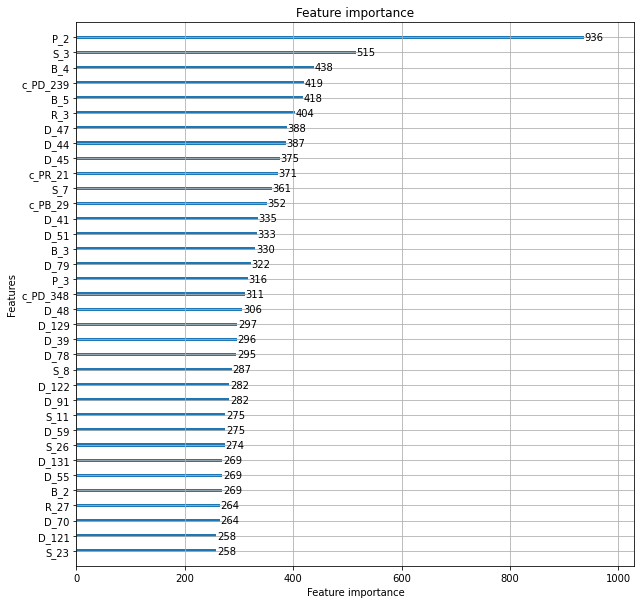

In [13]:
lgb.plot_importance(gbm, max_num_features = 35, figsize = (10,10))
plt.show()

In [14]:
# model = model.fit(X_train, y_train)

# Submissions

In [15]:
import numpy as np 
import pandas as pd 
import glob
from scipy.stats import rankdata

paths = [x for x in glob.glob('../input/*/*.csv') if 'amex-default-prediction' not in x]
dfs = [pd.read_csv(x) for x in paths]
dfs = [x.sort_values(by='customer_ID') for x in dfs]

paths = [x for x in glob.glob('../input/*/*.csv') if 'amex-default-prediction' not in x]
paths

for df in dfs:
    df['prediction'] = np.clip(df['prediction'], 0, 1)

In [16]:
paths = [x for x in glob.glob('../input/*/*.csv') if 'amex-default-prediction' not in x]
dfs = [pd.read_csv(x) for x in paths]
dfs = [x.sort_values(by='customer_ID') for x in dfs]

In [17]:
weights = [0.52, 0.85, 0.97, 0.57, 1.02, 0.8]# [0.52, 0.87, 0.95, 0.57, 1, 0.8]

In [18]:
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df, weight in zip(dfs, weights):
    submit['prediction'] += (df['prediction'] * weight)
    
submit['prediction'] /= np.sum(weights)

submit.to_csv('mean_submission.csv', index=None)

 
submit = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
submit['prediction'] = 0

for df, weight in zip(dfs, weights):
    submit['prediction'] += (rankdata(df['prediction'])/df.shape[0]) * weight
    
submit['prediction'] /= 4

In [19]:
test = pd.read_feather('../input/amexfeather/test_data.ftr')
df_train = test.groupby('customer_ID').tail(1).set_index('customer_ID')

In [20]:
df_train.columns

Index(['S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=189)

In [21]:
df_train = df_train.dropna(axis=1, thresh=int(0.80 * len(df_train)))

df_train["c_PD_239"]=df_train["D_39"]/(df_train["P_2"]*(-1)+0.0001)
df_train["c_PB_29"]=df_train["P_2"]*(-1)/(df_train["B_9"]*(1)+0.0001)
df_train["c_PR_21"]=df_train["P_2"]*(-1)/(df_train["R_1"]+0.0001)

df_train["c_BBBB"]=(df_train["B_9"]+0.001)/(df_train["B_23"]+df_train["B_3"]+0.0001)
df_train["c_BBBB1"]=(df_train["B_33"]*(-1))+(df_train["B_18"]*(-1)+df_train["S_25"]*(1)+0.0001)
df_train["c_BBBB2"]=(df_train["B_19"]+df_train["B_20"]+df_train["B_4"]+0.0001)

df_train["c_RRR0"]=(df_train["R_3"]+0.001)/(df_train["R_2"]+df_train["R_4"]+0.0001)
df_train["c_RRR1"]=(df_train["D_62"]+0.001)/(df_train["D_112"]+df_train["R_27"]+0.0001)

df_train["c_PD_348"]=df_train["D_48"]/(df_train["P_3"]+0.0001)
df_train["c_PD_355"]=df_train["D_55"]/(df_train["P_3"]+0.0001)

df_train["c_PD_439"]=df_train["D_39"]/(df_train["P_4"]+0.0001)
df_train["c_PB_49"]=df_train["B_9"]/(df_train["P_4"]+0.0001)
df_train["c_PR_41"]=df_train["R_1"]/(df_train["P_4"]+0.0001)


In [22]:
X = df_train.drop("S_2", axis=1)
X = X[Xname]

In [23]:
# Y_pred = model.predict_proba(X)

In [24]:
Y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)

In [25]:
Y_pred

array([-0.04305291, -0.00119861,  0.05329925, ...,  0.56848432,
        0.19189391,  0.03631712])

In [26]:
submit['prediction'] = (submit['prediction'])*(0.995)+(Y_pred)*(0.005)

In [27]:
submit.to_csv('submission.csv', index=None)    

In [28]:
submit.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.296674
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.042404
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.301839
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.379795
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.521729
